In [1]:
from pathlib import Path
import os
import glob

import matplotlib.pyplot as plt

import numpy as np
from scipy import sparse
from scipy.sparse.linalg import spsolve
from scipy import signal
import pandas as pd

from NEA_Patch_utils import *

import ipywidgets as widgets
from IPython.display import display, clear_output
import pyabf

In [2]:
os.chdir((Path("path-to-file")))

patch_file_list = []
nea_file_list = []
t = []

# sort all files into patch or nea data
for filename in glob.glob("20191212 analysis NEAandPatch/**/*.abf", recursive=True):
    if str(Path("/nea/")) in filename.lower():
        nea_file_list.append(filename)
    else: 
        patch_file_list.append(filename)
        
match_pairs = [] #tuples of patch, nea
# match the files by folder organization + pad number
for i in range(len(patch_file_list)):
    patch_file = patch_file_list[i]
    patch_file_comps = patch_file.split(str(Path("/")))
    for nea_file in nea_file_list:
        nea_file_comps = nea_file.split(str(Path("/")))
        if (patch_file_comps[-2] == nea_file_comps[-3]) and (patch_file_comps[-1][-6:] == nea_file_comps[-1][-6:]):
            match_pairs.append((patch_file, nea_file))
            nea_file_list.remove(nea_file)

print("All pairs matched?", len(patch_file_list) == len(match_pairs))
# uncomment to print unmatched pairs
# print("Unmatched Data:")
# print(nea_file_list)

# to preview the pairs of data
def plot_channel(abf_file, ax):
    f = pyabf.ABF(abf_file)
    f.setSweep(0)
    ax.plot(f.sweepX, f.sweepY)

def get_file_name(abf_file):
    return abf_file.split(str(Path("/")))[-1]

def plot_pairs(pair_idx, file_list):
    patch = file_list[pair_idx][0]
    nea = file_list[pair_idx][1]
    fig, ax = plt.subplots(2,1,figsize=(8,5))
    plot_channel(patch, ax[0])
    plot_channel(nea, ax[1])
    ax[0].set_title("Patch: "+ get_file_name(patch))
    ax[1].set_title("NEA: "+ get_file_name(nea))

pair_idx_slider = widgets.IntSlider(min=0, max=len(match_pairs)-1, step=1, value=0)
# uncomment below to run preview
%matplotlib inline
widgets.interact(plot_pairs,pair_idx=pair_idx_slider,file_list=widgets.fixed(match_pairs), continuous_update=True)
    

All pairs matched? True


interactive(children=(IntSlider(value=0, description='pair_idx', max=24), Output()), _dom_classes=('widget-int…

<function __main__.plot_pairs(pair_idx, file_list)>

In [3]:
unpacked = []
for i in range(len(match_pairs)):
    d = unpack_data(match_pairs[i])
    unpacked.append(d)


In [5]:
trimmed = []
for i in range(len(unpacked)):
    d = trim_data(unpacked[i])
    trimmed.append(d)
% store trimmed


Stored 'trimmed' (list)


interactive(children=(IntSlider(value=0, description='idx', max=24), Output()), _dom_classes=('widget-interact…

<function __main__.trim_data_viewer(idx, trimmed)>

<IPython.core.display.Javascript object>


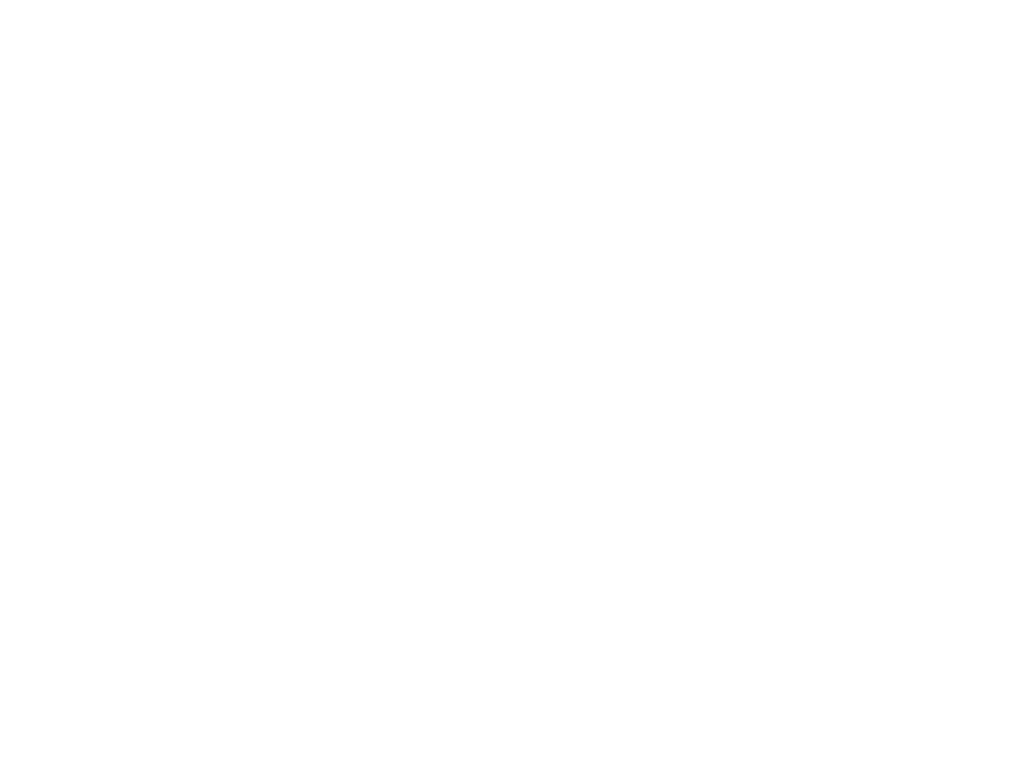

In [4]:
% store -r trimmed
% matplotlib notebook
idx_slider = widgets.IntSlider(min=0, max=len(trimmed)-1, step=1, value=0)
def trim_data_viewer(idx, trimmed):
    plot_trim_data(trimmed[idx])
widgets.interact(trim_data_viewer,idx=idx_slider,trimmed=widgets.fixed(trimmed),continuous_update=True)

In [42]:
def correlate_signal(signal_pair, crop_signal_time=10, crop_signal_start=25):
    if signal_pair is None:
        print("Data was not trimmed successfully. Please check raw data.")
    ((patch_t, patch_y, bas_patch), (nea_t, nea_y, bas_nea), data_pair_names) = signal_pair
    patch_y = patch_y - bas_patch
    nea_y = nea_y - bas_nea
    dx = np.mean(np.diff(nea_t))
    start = int(crop_signal_start/dx)
    stop = int((crop_signal_start+crop_signal_time)/dx)             
    patch_y_crop = patch_y[start:stop]
    nea_y_crop = nea_y[start:stop]
    nea_y_crop = nea_y_crop - min(nea_y_crop)
    patch_y_crop = patch_y_crop - min(patch_y_crop)
    nea_y_crop = nea_y_crop/max(nea_y_crop)
    patch_y_crop = patch_y_crop/max(patch_y_crop)
    patch_t_crop = patch_t[start:stop]
    nea_t_crop=nea_t[start:stop]
    shift = (np.argmax(signal.correlate(patch_y_crop, nea_y_crop, mode='full')) - len((nea_y_crop)-1))*dx
    raw = ((patch_t, patch_y), (nea_t, nea_y))
    crop = ((patch_t_crop, patch_y_crop), (nea_t_crop, nea_y_crop))
    
    return(raw, crop, shift, dx, data_pair_names)
def correlate_with_std(signal_pair, crop_signal_time=10, crop_signal_start=25):
    if signal_pair is None:
        print ("Data was not trimmed successfully. Please check raw data.")
    ((patch_t, patch_y, bas_patch), (nea_t, nea_y, bas_nea), data_pair_names) = signal_pair
    patch_y = patch_y - bas_patch
    nea_y = nea_y - bas_nea
    dx = np.mean(np.diff(nea_t))
    start = int(crop_signal_start/dx)
    stop = int((crop_signal_start+crop_signal_time)/dx)             
    patch_y_crop = patch_y[start:stop]
    nea_y_crop = nea_y[start:stop]
    nea_y_crop = nea_y_crop - min(nea_y_crop)
    patch_y_crop = patch_y_crop - min(patch_y_crop)
    nea_y_crop = nea_y_crop/max(nea_y_crop)
    patch_y_crop = patch_y_crop/max(patch_y_crop)
    patch_t_crop = patch_t[start:stop]
    nea_t_crop=nea_t[start:stop]
    # shift in time (add to nea) calculated by cross-correlation
    shift_idx = (np.argmax(signal.correlate(patch_y_crop, nea_y_crop, mode='full')) - len((nea_y_crop)-1))
    print(shift_idx)
    dx_idx = int(1/dx)
    if shift_idx >= 0:
        # need to trim off from patch
        patch_slice = patch_y_crop[shift_idx:shift_idx+dx_idx]
        nea_slice = nea_y_crop[0:dx_idx]
    else:
        patch_slice = patch_y_crop[0:dx_idx]
        nea_slice = nea_y_crop[-shift_idx:-shift_idx+dx_idx]
    patch_slice_std = rolling_std(patch_slice)[20:]
    nea_slice_std = rolling_std(nea_slice)[20:]
    shift_id2 = np.argmax(patch_slice_std) - np.argmax(nea_slice_std)
    print(shift_id2)
    shift = (shift_idx + shift_id2)*dx
    raw = ((patch_t, patch_y), (nea_t, nea_y))
    crop = ((patch_t_crop, patch_y_crop), (nea_t_crop, nea_y_crop))
    return(raw, crop, shift, dx, data_pair_names)

def plot_correlation(correlated_data, stretch=1):
    raw, crop, shift, dx, data_pair_names = correlated_data
    ((patch_t, patch_y), (nea_t, nea_y)) = raw 
    ((patch_t_crop, patch_y_crop), (nea_t_crop, nea_y_crop)) = crop
    shift_idx = int(shift/dx)
    if shift_idx >= 0:
        patch_y_crop = patch_y_crop[shift_idx:]
        patch_t_crop = patch_t_crop[shift_idx:]
        nea_t_crop = nea_t_crop[:-shift_idx]
        nea_y_crop = nea_y_crop[:-shift_idx]
    else:
        nea_t_crop = nea_t_crop[-shift_idx:]
        nea_y_crop = nea_y_crop[-shift_idx:]
        patch_t_crop = patch_t_crop[:shift_idx]
        patch_y_crop = patch_y_crop[:shift_idx]
    nea_t_crop = np.linspace(patch_t_crop[0], patch_t_crop[-1]*stretch, len(patch_t_crop))
    fig, ax = plt.subplots(2,1,figsize=(8,6))
    fig.suptitle(get_file_name(data_pair_names[1]))
    ax[0].plot(patch_t, patch_y, label='patch')
    ax[0].plot(nea_t, nea_y, label='NEA')
    ax[0].set_title('Pre-align preview')
    ax[0].legend(loc=1)
    ax[1].plot(patch_t_crop, patch_y_crop, label='patch')
    ax[1].plot(nea_t_crop, nea_y_crop, label='NEA')
    ax[1].set_title('Aligned data')
    ax[1].set_ylabel('arbitrary units')
    ax[1].set_xlabel('time')
    ax[1].legend(loc=1)
                    

In [43]:
class NEA_Patch_Alignment:
    def __init__(self, pair_data, trimmed_data=None):
        self.num_pairs = len(pair_data)
        self.pair_data = pair_data
        
        if trimmed_data is None:
            print("Trimmed data input not found. Trimming data (this may take a while)...")
            trimmed = []
            for i in range(self.num_pairs):
                d = trim_data(self.pair_data[i])
                trimmed.append(d)
            self.trimmed_data = trimmed
            print("Data Trimmed")
        else:
            self.trimmed_data = trimmed_data
        
        self.select_slider = widgets.IntSlider(min=0, max=len(pair_data)-1, step=1, description ='Select pair')
        self.duration_text = widgets.FloatText(value=10,description='Duration')
        self.start_text = widgets.FloatText(value=50, description='Start')
        self.stretch_text = widgets.FloatText(value=1, description="Stretch Factor")
        
        self.update_button = widgets.Button(description='Update Plot')
        
        self.output = widgets.Output()
        display(self.select_slider, self.duration_text, self.start_text, self.stretch_text, self.update_button, self.output)
        
        self.update_button.on_click(self.update_alignment)
        
    
    def update_alignment(self, button):
        with self.output:
            clear_output()
            idx = self.select_slider.value
            crop_t = self.duration_text.value
            crop_start = self.start_text.value
            stretch_factor = self.stretch_text.value
            corr = correlate_signal(self.trimmed_data[idx], crop_t, crop_start)
            plot_correlation(corr)
            corr2 = correlate_with_std(self.trimmed_data[idx], crop_t, crop_start)
            plot_correlation(corr2, stretch=stretch_factor)
            
#%store -r trimmed
%matplotlib notebook
NEA_Patch_Alignment(match_pairs, trimmed)     

IntSlider(value=0, description='Select pair', max=24)

FloatText(value=10.0, description='Duration')

FloatText(value=50.0, description='Start')

FloatText(value=1.0, description='Stretch Factor')

Button(description='Update Plot', style=ButtonStyle())

Output()

24 lines
& nea amplitudes
& before/after poration for patch (amplitude, peak to peak distance, apd (10/50/90)
& cross correlation for patch and nea/similarity over time (start at poration w/blanking)
& save the plots ^ 